In [1]:
from torchvision import datasets, transforms
import torch

dataset_train_t = datasets.CIFAR10('.', train = True, download = True, transform = transforms.ToTensor())
dataset_val_t = datasets.CIFAR10('.', train = False, download = True, transform = transforms.ToTensor())

imgs = torch.stack([img_t for img_t,_ in dataset_train_t], dim=3)
means = imgs.view(3,-1).mean(dim=1)
stds = imgs.view(3,-1).std(dim=1)
dataset_train_transformed = datasets.CIFAR10('.', train = True, download = True,
                                            transform = transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize(means.numpy(), stds.numpy())
                                            ]))
dataset_val_transformed = datasets.CIFAR10('.', train = False, download = True,
                                            transform = transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize(means.numpy(), stds.numpy())
                                            ]))

label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']
dataset_train = [(img, label_map[label]) for (img, label) in dataset_train_transformed if label in [0,2]]
dataset_val = [(img, label_map[label]) for (img, label) in dataset_val_transformed if label in [0,2]]
print(len(dataset_train), len(dataset_val))

Using downloaded and verified file: ./cifar-10-python.tar.gz
Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
10000 2000


In [19]:
import torch.nn as nn

conv = nn.Conv2d(3, 16, kernel_size=3)
print(conv.weight.shape) # the shape of batch of kernels in conv
print(conv.bias.shape) # the shape of biases in conv

conv1 = nn.Conv2d(3, 16, kernel_size=5)
print(conv1.weight.shape) # the shape of batch of kernels in conv
print(conv1.bias.shape) # the shape of biases in conv

torch.Size([16, 3, 3, 3])
torch.Size([16])
torch.Size([16, 3, 5, 5])
torch.Size([16])


In [20]:
img, lbl = dataset_train[0]
out = conv(img.unsqueeze(0))
out.shape

torch.Size([1, 16, 30, 30])

In [21]:
img, lbl = dataset_train[0]
out = conv1(img.unsqueeze(0))
out.shape

torch.Size([1, 16, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


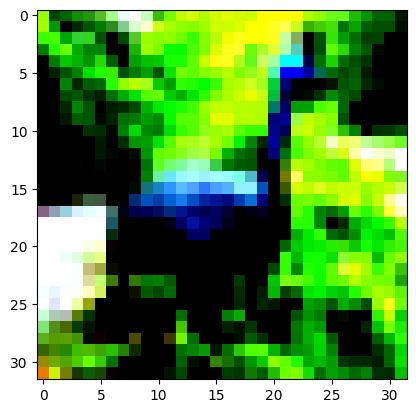

In [22]:
from matplotlib import pyplot as plt

plt.imshow(img.permute(1,2,0))

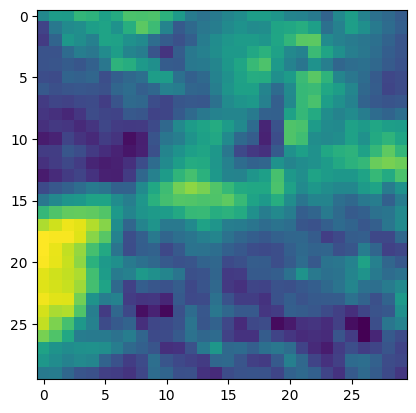

In [30]:
out = conv(img.unsqueeze(0))
plt.imshow(out[0,0].detach())

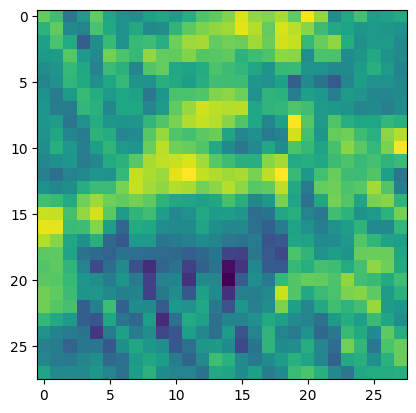

In [33]:
out = conv1(img.unsqueeze(0))
plt.imshow(out[0,15].detach())

In [44]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
print(conv.weight.shape) # the shape of batch of kernels in conv
print(conv.bias.shape) # the shape of biases in conv

conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
print(conv1.weight.shape) # the shape of batch of kernels in conv
print(conv1.bias.shape) # the shape of biases in conv

torch.Size([16, 3, 3, 3])
torch.Size([16])
torch.Size([16, 3, 5, 5])
torch.Size([16])


In [45]:
out = conv(img.unsqueeze(0))
out.shape
#plt.imshow(out[0,15].detach())

torch.Size([1, 16, 32, 32])

In [47]:
out = conv1(img.unsqueeze(0))
out.shape

torch.Size([1, 16, 32, 32])

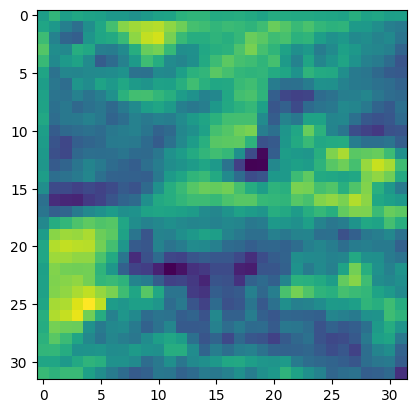

In [49]:
out = conv(img.unsqueeze(0))
plt.imshow(out[0,0].detach())

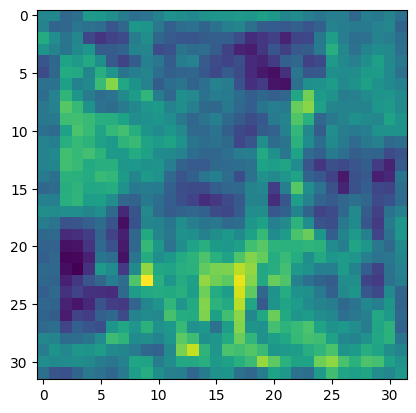

In [53]:
out = conv1(img.unsqueeze(0))
plt.imshow(out[0,0].detach())

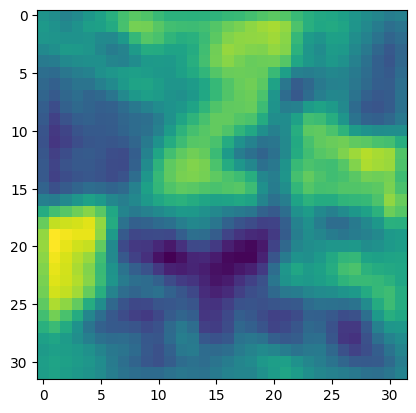

In [61]:
with torch.no_grad():
    conv.bias.zero_()
    conv.weight.fill_(1.0/9.0) #average in each channel and then add together within a neighborhood of 3 *3

out = conv(img.unsqueeze(0))
plt.imshow(out[0,1].detach())

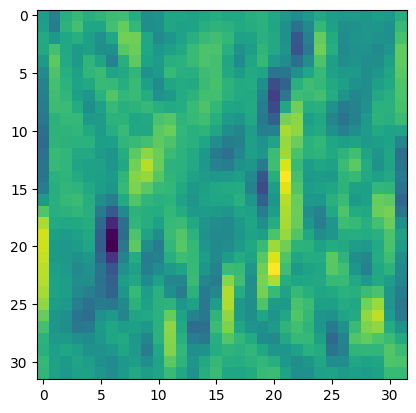

In [63]:
with torch.no_grad():
    conv.bias.zero_()
    conv.weight[:] = torch.tensor([[-1.0, 0, 1.0],
                                   [-1.0, 0, 1.0],
                                   [-1.0, 0, 1.0]]) #identify vertical edges

out = conv(img.unsqueeze(0))
plt.imshow(out[0,1].detach())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


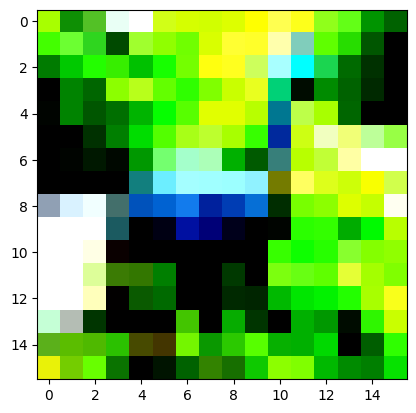

In [67]:
pool = nn.MaxPool2d(2)
out = pool(img)
plt.imshow(out.permute(1,2,0))

In [73]:
model = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1), # output: 1 * 16 * 32 * 32
                                                                  # kernel: 3 * 3 * 3
                                                                  # batch of kernels: 16 * 3 * 3 * 3 (weight tensor)
                                                                  # biases: 1 bias per kernel, in total 16
                      nn.Tanh(),
                      nn.MaxPool2d(2), # input: 1 * 16 * 32 * 32, output: 1 * 16 * 16 * 16
                      
                      nn.Conv2d(16, 8, kernel_size=3, padding=1), # output: 1 * 8 * 16 * 16
                                                                  # kernel: 16 * 3 * 3
                                                                  # batch of kernels: 8 * 16 * 3 * 3 (weight)
                                                                  # biases: 1 bias per kernel, in total 8
                      nn.Tanh(),
                      nn.MaxPool2d(2), #input: 1 * 8 * 16 * 16, output: 1 * 8 * 8 * 8
                      nn.Flatten(),
                      nn.Linear(512, 32), # output: 32
                                          # 32 neurons, each having 512 weights, and 1 bias
                                          # weights: 32 * 512, bias: 32
                      nn.Tanh(),
                      nn.Linear(32,2), # output: 2
                                       # 2 neurons, each having 32 weights, and 1 bias
                                       # weights: 2 * 32, bias: 2
                      nn.Softmax(dim=1))

In [74]:
model(img.unsqueeze(0))

tensor([[0.4552, 0.5448]], grad_fn=<SoftmaxBackward0>)

In [78]:
[param.shape for param in model.parameters()]

[torch.Size([16, 3, 3, 3]),
 torch.Size([16]),
 torch.Size([8, 16, 3, 3]),
 torch.Size([8]),
 torch.Size([32, 512]),
 torch.Size([32]),
 torch.Size([2, 32]),
 torch.Size([2])]

In [79]:
[param.numel() for param in model.parameters()]

[432, 16, 1152, 8, 16384, 32, 64, 2]

In [80]:
sum([param.numel() for param in model.parameters()])

18090